In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from linearmodels import PanelOLS
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import shapiro, levene, bartlett, f_oneway, fligner
from statsmodels.graphics.gofplots import qqplot

In [2]:
data_basa = pd.read_excel('Х5.xlsx')

In [3]:
print(data_basa.shape)
print(data_basa['new_id'].nunique())

(256723, 18)
21743


In [4]:
data_basa.isnull().sum()
data_basa['Месяц'].unique() # месяцы нормальны по значения, но нужно проверить количество
data_grup_mag = data_basa.groupby('new_id', as_index=False)
print(data_grup_mag.agg({'Месяц':'count'})['Месяц'].unique()) # есть проблема

duplicate_ids = data_basa.groupby(['new_id', 'Месяц']).size().reset_index(name='count')
duplicate_ids = duplicate_ids[duplicate_ids['count'] > 1]['new_id'].unique()
print("new_id с повторяющимися месяцами:", duplicate_ids) # только один с ID 13842
df_x = data_basa.groupby('new_id', as_index = False).agg({'Месяц':'count'})
indx = df_x[df_x['Месяц'] != 12]['new_id']

[12 10  8 11  3  2  4  5  7  9  6 24]
new_id с повторяющимися месяцами: [13842]


In [5]:
print(data_basa[data_basa['Численность населения'] == 0].shape)

(13972, 18)


In [6]:
data = data_basa[(data_basa['Численность населения'] != 0)  & (~data_basa['new_id'].isin(indx))]

In [7]:
print(data.shape)
print(data_basa.shape)
print((256723-234876)/256723*100)

(234876, 18)
(256723, 18)
8.509950413480677


In [8]:
data.columns
data['Выручка'] = data['Средний чек']*data['Трафик']

C:\Users\Michael\AppData\Local\Temp\ipykernel_13244\2622487778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Выручка'] = data['Средний чек']*data['Трафик']


In [9]:
pd.options.mode.copy_on_write = True
data.rename(columns={'Маркетплейсы, доставки, постаматы (100 м)' : 'пвз'}, inplace = True)
mess = [1,2,3,4,5,6,7,8,9,10,11,12]
mags = data['new_id'].unique()
A = []
for mag in mags:
    df = data[data['new_id'] == mag] # Выбираем магазин
    S = 0
    for mes in mess:
        df1 = df[df['Месяц']==mes] # смотрим месяц
        x = df1['Средний чек'].sum()
        y = df1['Трафик'].sum()
        S += x*y # кладём в общую копилку
    A.append(S/12)  # выручка на покупку
df2 = data.groupby('new_id', as_index = False).agg({'Трафик':'mean','Средний чек':'mean', 'пвз':'mean', 'Остановки (300 м)':'mean'}).copy()
df2['выручка'] = A
df2.to_csv('Групированный_датасет.csv')

In [10]:
pd.options.mode.copy_on_write = True
data.rename(columns={'Маркетплейсы, доставки, постаматы (100 м)' : 'пвз'}, inplace = True)
df2 = pd.read_csv('Групированный_датасет.csv')
df2 = df2.rename(columns = {'выручка':'Выручка'})
df2['Население'] = data.groupby('new_id', as_index = False).agg({'Численность населения':'mean'})['Численность населения']
df2

,Unnamed: 0,new_id,Трафик,Средний чек,пвз,Остановки (300 м),Выручка,Население
0,0,0,56270.916667,836.085288,0.0,0.0,4.714955e+07,10177.0
1,1,1,71995.916667,663.014014,1.0,3.0,4.792209e+07,1544376.0
2,2,2,63466.583333,1087.083774,10.0,1.0,6.900917e+07,74183.0
3,3,3,69567.500000,1622.269179,3.0,3.0,1.131578e+08,314934.0
4,4,4,65873.750000,1126.653308,3.0,11.0,7.417622e+07,12506468.0
...,...,...,...,...,...,...,...,...
19568,19568,21415,48557.250000,645.992342,0.0,1.0,3.326007e+07,321479.0
19569,19569,21420,51364.833333,608.848210,0.0,2.0,3.292299e+07,1028036.0
19570,19570,21422,60842.916667,710.220389,0.0,2.0,4.572402e+07,1028036.0
19571,19571,21428,47832.250000,635.220353,0.0,0.0,3.195083e+07,1028036.0


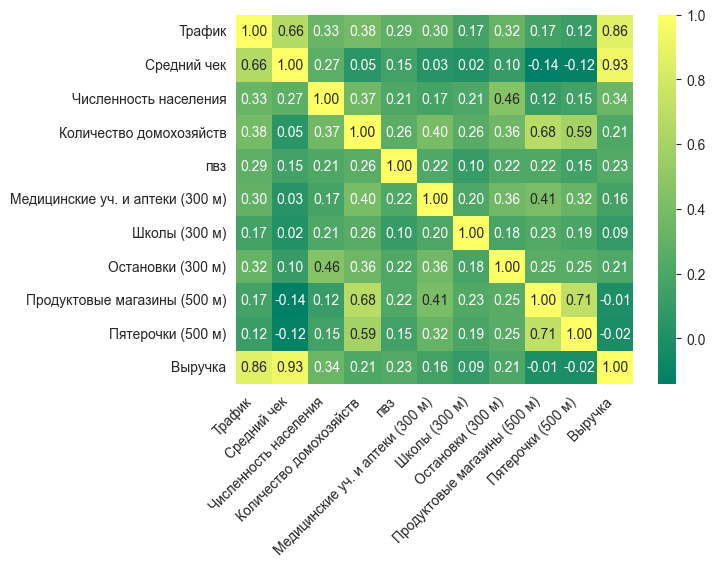

In [11]:
clear = data[['Трафик', 'Средний чек', 'Численность населения', 'Количество домохозяйств'\
              ,'пвз', 'Медицинские уч. и аптеки (300 м)', 'Школы (300 м)', 'Остановки (300 м)', 'Продуктовые магазины (500 м)', 'Пятерочки (500 м)', 'Выручка']]
correlation_matrix = clear.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='summer', fmt='.2f')
plt.xticks(rotation=45, ha='right')
plt.show()

In [12]:
def create_pvs_categories(value):
    if 0 == value:
        return 'нет'
    elif 1 == value:
        return 'мало'
    elif 2 <= value <= 4:
        return 'средне'
    else:
        return 'много'
df2['pvz_groups'] = df2['пвз'].apply(create_pvs_categories)

In [13]:
import plotly.graph_objects as go
from scipy.stats import gaussian_kde

data_vr = df2['Выручка'].dropna()
plt.figure(figsize = (8,8))
# Статистики отдельно
mean_val = data_vr.mean()
median_val = data_vr.median()
std_val = data_vr.std()

print(f"Среднее:  {mean_val:.2f}")
print(f"Медиана:  {median_val:.2f}")
print(f"Ст. откл: {std_val:.2f}")

dark_green = "#088F34"   # тёмно-зелёный
light_green = "#A0C61A"  # светло-зелёный

# --- KDE + подгонка под счёт столбиков ---

# Сетка для KDE
x_grid = np.linspace(data_vr.min(), data_vr.max(), 400)
kde = gaussian_kde(data_vr)
y_kde = kde(x_grid)

# Считаем гистограмму, чтобы понять реальные высоты столбиков (в штуках)
hist_counts, bin_edges = np.histogram(data_vr, bins=60)
hist_max = hist_counts.max()

# Масштабируем KDE под высоту гистограммы (чисто визуально)
y_kde_scaled = y_kde * (hist_max / y_kde.max())

# --- Рисуем фигуру ---
fig = go.Figure()

# Гистограмма с количеством наблюдений
fig.add_trace(
    go.Histogram(
        x=data_vr,
        nbinsx=100,
        name="Распределение выручки",
        marker=dict(
            color=dark_green,
            line=dict(color=light_green, width=1)
        ),
        opacity=0.65,
        # по умолчанию histnorm=None → это именно количество
        # histnorm="count"
    )
)

# Сглаженная кривая сверху (подогнана по масштабу)
fig.add_trace(
    go.Scatter(
        x=x_grid,
        y=y_kde_scaled,
        mode="lines",
        name="Сглаженная форма распределения",
        line=dict(color=dark_green, width=3),
        fill="tozeroy",
        fillcolor="rgba(8,143,52,0.15)"
    )
)

# --- Оформление ---
fig.update_layout(
    title="Распределение выручки",
    xaxis_title="Выручка",
    yaxis_title="Количество наблюдений",
    template="simple_white",
    bargap=0.05,
)


fig.show()


Среднее:  60270546.16
Медиана:  51643358.10
Ст. откл: 31544952.87


<Figure size 800x800 with 0 Axes>

0.2369132194910726


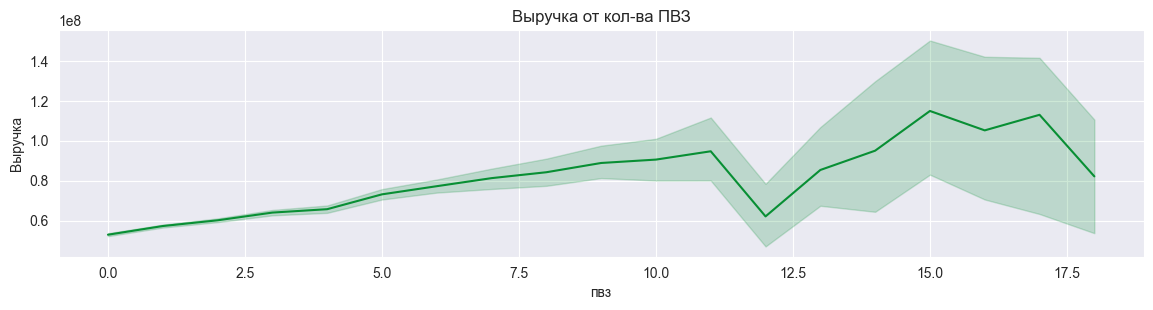

In [14]:
plt.figure(figsize = (14,10))

plt.subplot(3,1,1)
sns.lineplot(data = df2, x = 'пвз', y = 'Выручка', color = dark_green)
plt.title('Выручка от кол-ва ПВЗ')

print(df2['пвз'].corr(df2['Выручка']))

C:\Users\Michael\AppData\Local\Temp\ipykernel_13244\1770219671.py:11: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



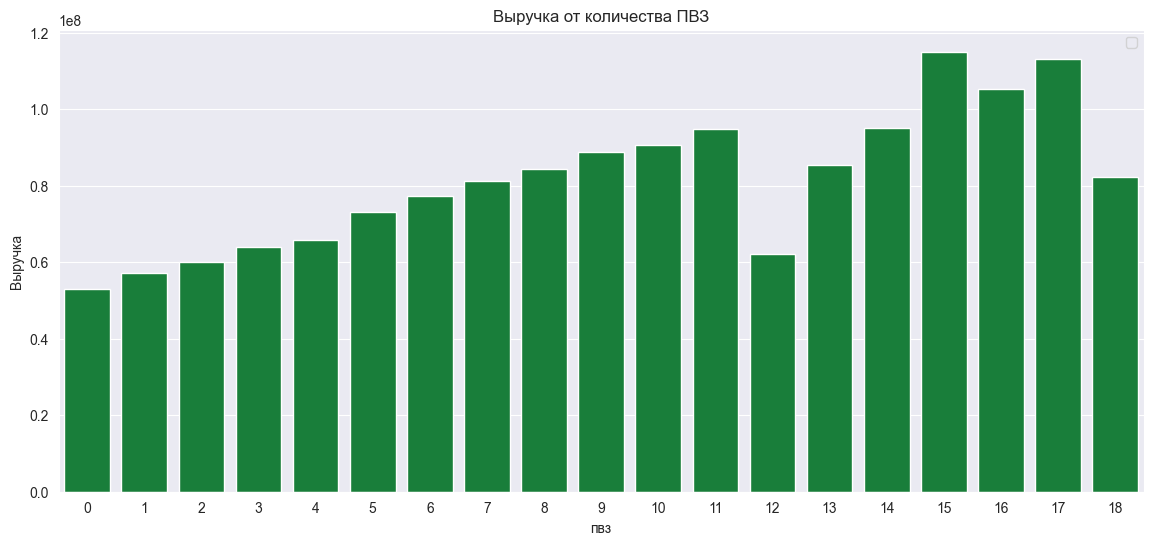

In [15]:
group_bar = df2.groupby('пвз', as_index = False).agg({'Выручка':'mean'})

plt.figure(figsize = (14,6))
x = group_bar['пвз']
y = group_bar['Выручка']
x = x.astype(int)
ax = sns.barplot(x = x, y = y, color = dark_green, order=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])

# Настройки
plt.title('Выручка от количества ПВЗ')
plt.legend()
plt.show()

0.2959327489026961


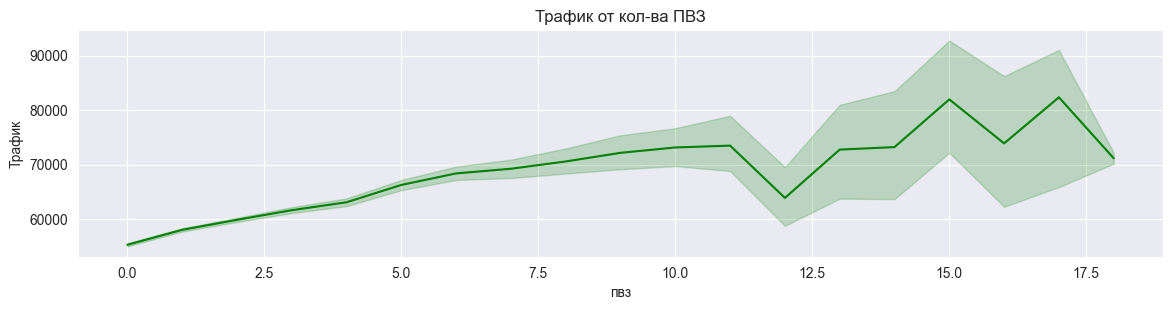

In [16]:
plt.show()
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
sns.lineplot(data=df2, x='пвз', y='Трафик', color='green')
plt.title('Трафик от кол-ва ПВЗ')

print(df2['пвз'].corr(df2['Трафик']))

0.16141328825285958


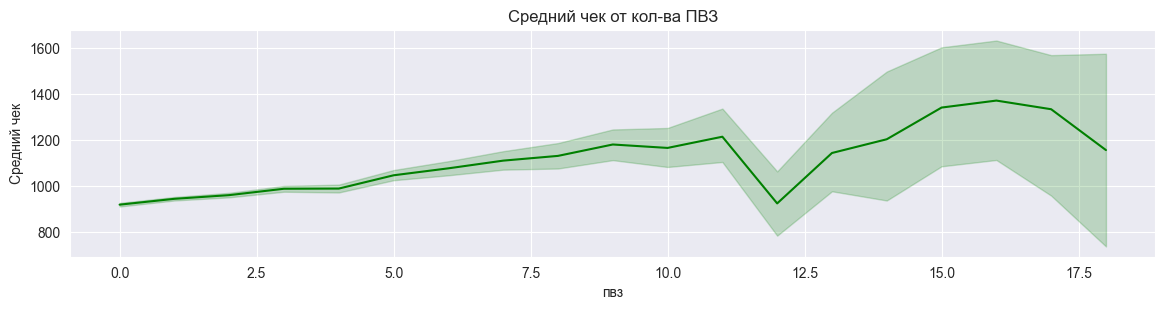

In [17]:
plt.show()
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
sns.lineplot(data=df2, x='пвз', y='Средний чек', color='green')
plt.title('Средний чек от кол-ва ПВЗ')

print(df2['пвз'].corr(df2['Средний чек']))

In [18]:
# проверка на нормальность
for group_name in ['нет', 'мало', 'средне', 'много']:
    group_data = df2[df2['pvz_groups'] == group_name]['Выручка']
    if len(group_data) > 3:
        stat, p = stats.shapiro(group_data)
        print(f"{group_name:15} | p = {p:.4f} | n = {len(group_data)} {group_data.mean()} {group_data.median()}")

нет             | p = 0.0000 | n = 4690 52871621.58533627 46883100.31436397
мало            | p = 0.0000 | n = 5634 57229336.23971135 49599680.72578765
средне          | p = 0.0000 | n = 7254 62402714.21760163 53673689.81677745
много           | p = 0.0000 | n = 1995 78500313.50314127 68560600.36539137


C:\Users\Michael\PyCharmMiscProject\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5634.

C:\Users\Michael\PyCharmMiscProject\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7254.



In [19]:
group1 = df2[df2['pvz_groups'] == 'нет']['Выручка']
group2 = df2[df2['pvz_groups'] == 'мало']['Выручка']
group3 = df2[df2['pvz_groups'] == 'средне']['Выручка']
group4 = df2[df2['pvz_groups'] == 'много']['Выручка']

# Тест Левена на равенство дисперсий
levene_stat, levene_p = stats.levene(group1, group2, group3, group4)

if levene_p < 0.05:
    print(f"Дисперсии не равны! p-value = {levene_p}")
else:
    print("Дисперсии равны")

Дисперсии не равны! p-value = 1.1726213734596703e-108


C:\Users\Michael\AppData\Local\Temp\ipykernel_13244\3677939263.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




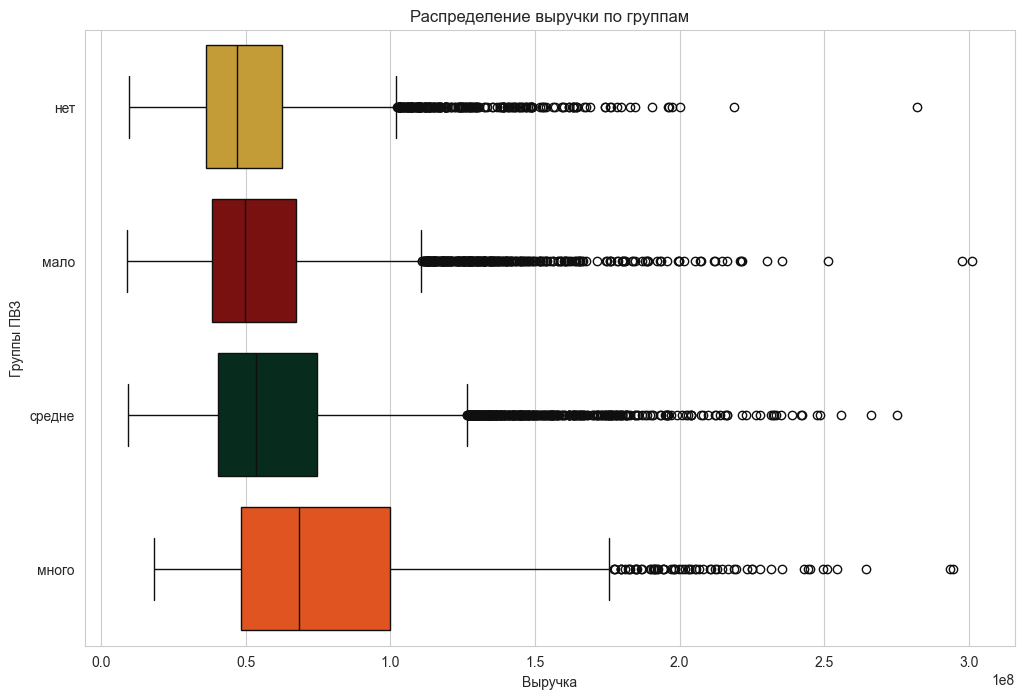

In [20]:
#боксплоты пвз-выручка
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.boxplot(data=df2, y='pvz_groups',
    x='Выручка',
    order=['нет', 'мало', 'средне', 'много'],
    orient='h',
    palette = ["#DAA520", "#8B0000", "#013220", "#FF4500"]
    )
plt.title('Распределение выручки по группам')
plt.ylabel('Группы ПВЗ')
plt.xlabel('Выручка')
plt.show()

C:\Users\Michael\AppData\Local\Temp\ipykernel_13244\3772616949.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




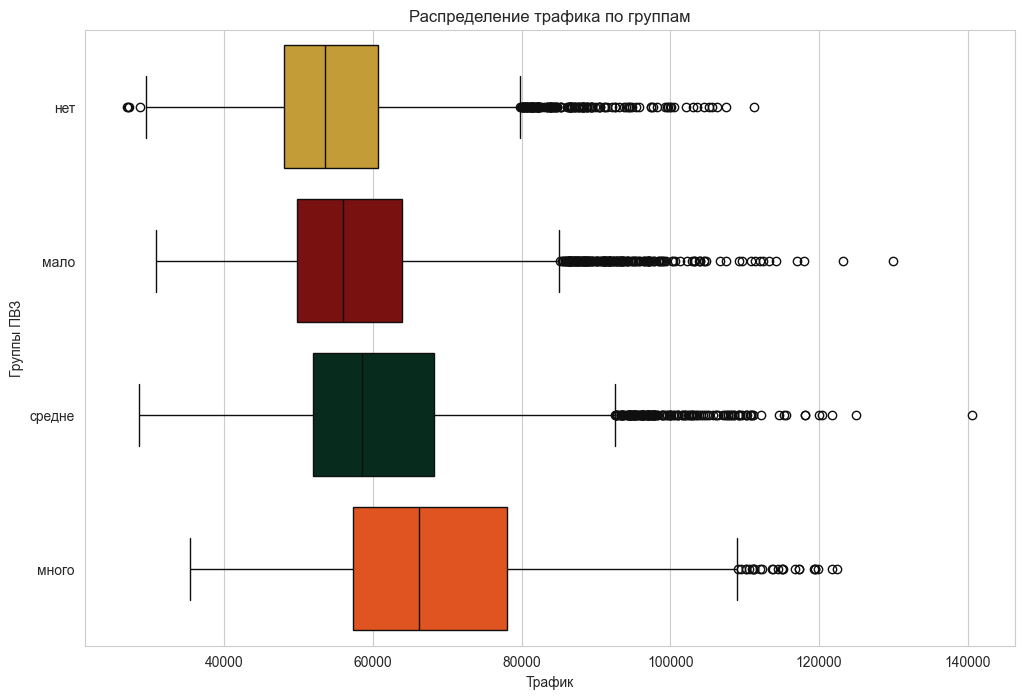

In [21]:
#боксплоты пвз-трафик
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.boxplot(data=df2, y='pvz_groups',
            x='Трафик',
            order=['нет', 'мало', 'средне', 'много'],
            orient='h',
            palette=["#DAA520", "#8B0000", "#013220", "#FF4500"]
            )
plt.title('Распределение трафика по группам')
plt.ylabel('Группы ПВЗ')
plt.xlabel('Трафик')
plt.show()

C:\Users\Michael\AppData\Local\Temp\ipykernel_13244\2967494161.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




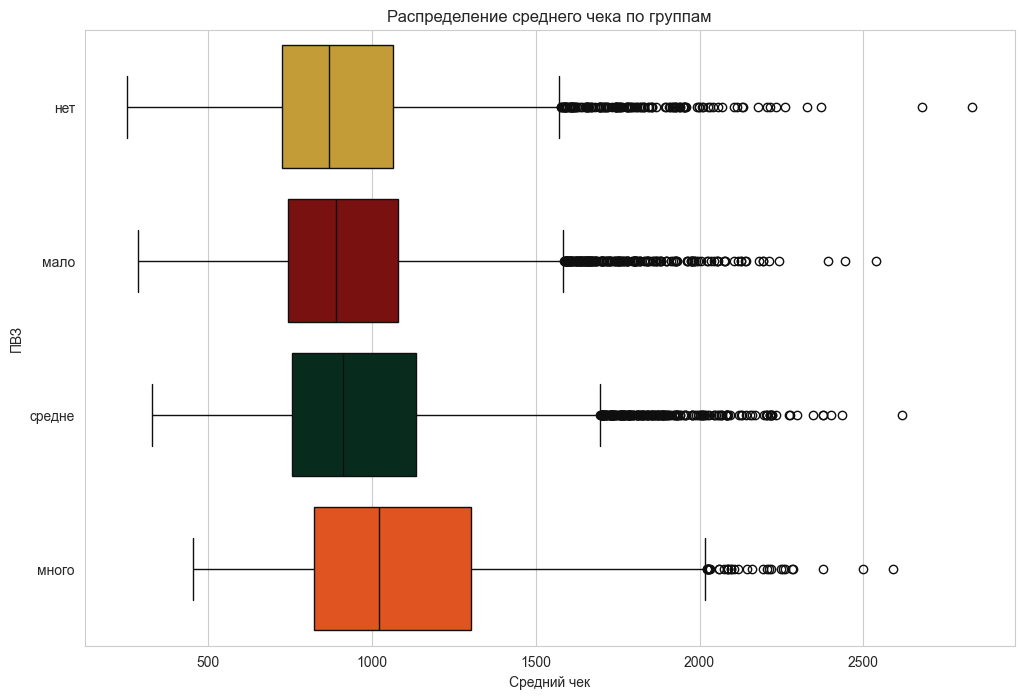

In [22]:
#боксплоты пвз-средний чек
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.boxplot(data=df2, y='pvz_groups',
    x='Средний чек',
    order=['нет', 'мало', 'средне', 'много'],
    orient='h',
    palette = ["#DAA520", "#8B0000", "#013220", "#FF4500"]
    )
plt.title('Распределение среднего чека по группам')
plt.ylabel('ПВЗ')
plt.xlabel('Средний чек')
plt.show()

C:\Users\Michael\AppData\Local\Temp\ipykernel_13244\3501626901.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




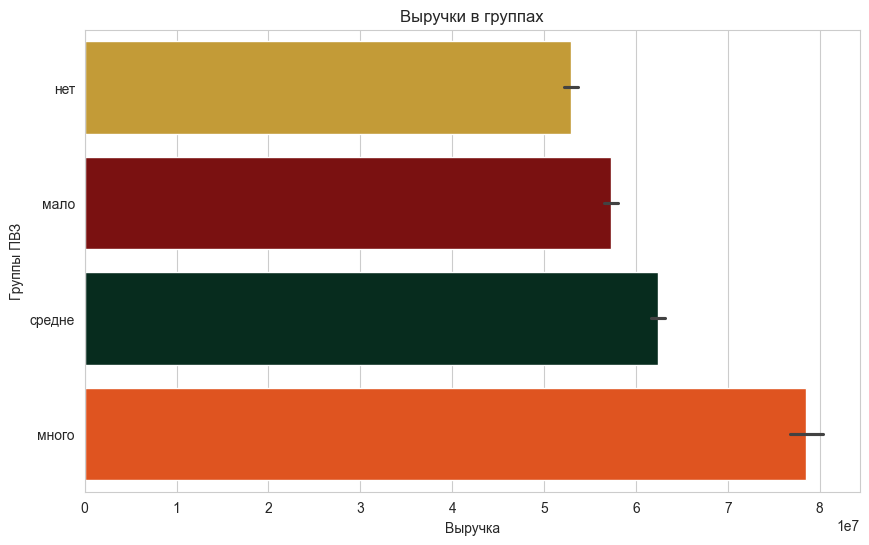

In [23]:
#барплоты пвз-выручка
plt.figure(figsize=(10,6))
sns.barplot(data=df2, y='pvz_groups',
    x='Выручка',
    order=['нет', 'мало', 'средне', 'много'],
    palette = ["#DAA520", "#8B0000", "#013220", "#FF4500"])
plt.title('Выручки в группах')
plt.ylabel('Группы ПВЗ')
plt.xlabel('Выручка')
plt.show()

4690 5634 7254 1995
52871621.58533627 57229336.23971135 62402714.21760163 78500313.50314127
46883100.31436397 49599680.72578765 53673689.81677745 68560600.36539137


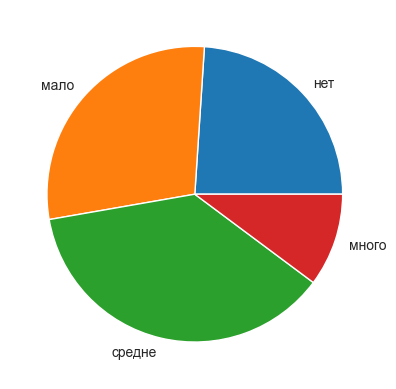

In [24]:
x  = pd.Series([df2[df2['pvz_groups'] == 'нет']['new_id'].nunique(), df2[df2['pvz_groups'] == 'мало']['new_id'].nunique(), df2[df2['pvz_groups'] == 'средне']['new_id'].nunique(), df2[df2['pvz_groups'] == 'много']['new_id'].nunique()])
y = ['нет', 'мало','средне','много']
print(df2[df2['pvz_groups'] == 'нет']['new_id'].nunique(), df2[df2['pvz_groups'] == 'мало']['new_id'].nunique(), df2[df2['pvz_groups'] == 'средне']['new_id'].nunique(), df2[df2['pvz_groups'] == 'много']['new_id'].nunique())
print(df2[df2['pvz_groups'] == 'нет']['Выручка'].mean(), df2[df2['pvz_groups'] == 'мало']['Выручка'].mean(), df2[df2['pvz_groups'] == 'средне']['Выручка'].mean(), df2[df2['pvz_groups'] == 'много']['Выручка'].mean())
print(df2[df2['pvz_groups'] == 'нет']['Выручка'].median(), df2[df2['pvz_groups'] == 'мало']['Выручка'].median(), df2[df2['pvz_groups'] == 'средне']['Выручка'].median(), df2[df2['pvz_groups'] == 'много']['Выручка'].median())
plt.pie(x, labels = y)
plt.show()

In [25]:
# Тест Краскела-Уоллиса (
from scipy.stats import kruskal
groups = [df2[df2['pvz_groups'] == group]['Выручка'].dropna() for group in df2['pvz_groups'].unique()]
h_stat, kruskal_p = kruskal(*groups)
print(f"Краскела-Уоллиса: H = {h_stat:.2f}, p = {kruskal_p:.6f}")

Краскела-Уоллиса: H = 867.04, p = 0.000000


In [85]:
import scikit_posthocs as sp

dunn_result = sp.posthoc_dunn(
        df2,
        val_col='Выручка',
        group_col='pvz_groups',
        p_adjust='holm'  # метод коррекции
    )
# Более читаемый формат
print("\n" + "="*60)
print("ПОПАРНЫЕ СРАВНЕНИЯ (тест Данна):")

# Преобразуем матрицу в список значимых сравнений
comparisons = []
groups = dunn_result.columns.tolist()

for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        g1, g2 = groups[i], groups[j]
        p_val = dunn_result.loc[g1, g2]
        comparisons.append((g1, g2, p_val))

# Сортируем по p-value
comparisons.sort(key=lambda x: x[2])

for g1, g2, p_val in comparisons:
    symbol = "✓" if p_val < 0.05 else "✗"
    print(f"  {g1:12} vs {g2:12}: p = {p_val:.4f} {symbol} {round(df2[df2['pvz_groups'] == g1]['Выручка'].median() - df2[df2['pvz_groups'] == g2]['Выручка'].median())}")


ПОПАРНЫЕ СРАВНЕНИЯ (тест Данна):
  много        vs нет         : p = 0.0000 ✓ 21677500
  мало         vs много       : p = 0.0000 ✓ -18960920
  много        vs средне      : p = 0.0000 ✓ 14886911
  нет          vs средне      : p = 0.0000 ✓ -6790590
  мало         vs средне      : p = 0.0000 ✓ -4074009
  мало         vs нет         : p = 0.0000 ✓ 2716580


In [27]:
# Тест Краскела-Уоллиса (
from scipy.stats import kruskal

groups = [df2[df2['pvz_groups'] == group]['Трафик'].dropna() for group in df2['pvz_groups'].unique()]
h_stat, kruskal_p = kruskal(*groups)
print(f"Краскела-Уоллиса: H = {h_stat:.2f}, p = {kruskal_p:.6f}")

Краскела-Уоллиса: H = 1555.74, p = 0.000000


In [28]:
dunn_result = sp.posthoc_dunn(
        df2,
        val_col='Трафик',
        group_col='pvz_groups',
        p_adjust='holm'  # метод коррекции
    )
# Более читаемый формат
print("\n" + "="*60)
print("ПОПАРНЫЕ СРАВНЕНИЯ (тест Данна):")

# Преобразуем матрицу в список значимых сравнений
comparisons = []
groups = dunn_result.columns.tolist()

for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        g1, g2 = groups[i], groups[j]
        p_val = dunn_result.loc[g1, g2]
        comparisons.append((g1, g2, p_val))

# Сортируем по p-value
comparisons.sort(key=lambda x: x[2])

for g1, g2, p_val in comparisons:
    symbol = "✓" if p_val < 0.05 else "✗"
    print(f"  {g1:12} vs {g2:12}: p = {p_val:.4f} {symbol} {round(df2[df2['pvz_groups'] == g1]['Трафик'].median() - df2[df2['pvz_groups'] == g2]['Трафик'].median())}")


ПОПАРНЫЕ СРАВНЕНИЯ (тест Данна):
  много        vs нет         : p = 0.0000 ✓ 12595
  мало         vs много       : p = 0.0000 ✓ -10134
  нет          vs средне      : p = 0.0000 ✓ -4962
  много        vs средне      : p = 0.0000 ✓ 7633
  мало         vs средне      : p = 0.0000 ✓ -2500
  мало         vs нет         : p = 0.0000 ✓ 2462


In [29]:
# Тест Краскела-Уоллиса (
from scipy.stats import kruskal
groups = [df2[df2['pvz_groups'] == group]['Средний чек'].dropna() for group in df2['pvz_groups'].unique()]
h_stat, kruskal_p = kruskal(*groups)
print(f"Краскела-Уоллиса: H = {h_stat:.2f}, p = {kruskal_p:.6f}")

Краскела-Уоллиса: H = 383.85, p = 0.000000


In [30]:
dunn_result = sp.posthoc_dunn(
        df2,
        val_col='Средний чек',
        group_col='pvz_groups',
        p_adjust='holm'  # метод коррекции
    )
# Более читаемый формат
print("\n" + "="*60)
print("ПОПАРНЫЕ СРАВНЕНИЯ (тест Данна):")

# Преобразуем матрицу в список значимых сравнений
comparisons = []
groups = dunn_result.columns.tolist()

for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        g1, g2 = groups[i], groups[j]
        p_val = dunn_result.loc[g1, g2]
        comparisons.append((g1, g2, p_val))

# Сортируем по p-value
comparisons.sort(key=lambda x: x[2])

for g1, g2, p_val in comparisons:
    symbol = "✓" if p_val < 0.05 else "✗"
    print(f"  {g1:12} vs {g2:12}: p = {p_val:.4f} {symbol} {round(df2[df2['pvz_groups'] == g1]['Средний чек'].median() - df2[df2['pvz_groups'] == g2]['Средний чек'].median())}")


ПОПАРНЫЕ СРАВНЕНИЯ (тест Данна):
  много        vs нет         : p = 0.0000 ✓ 152
  мало         vs много       : p = 0.0000 ✓ -131
  много        vs средне      : p = 0.0000 ✓ 109
  нет          vs средне      : p = 0.0000 ✓ -43
  мало         vs средне      : p = 0.0000 ✓ -22
  мало         vs нет         : p = 0.0000 ✓ 21


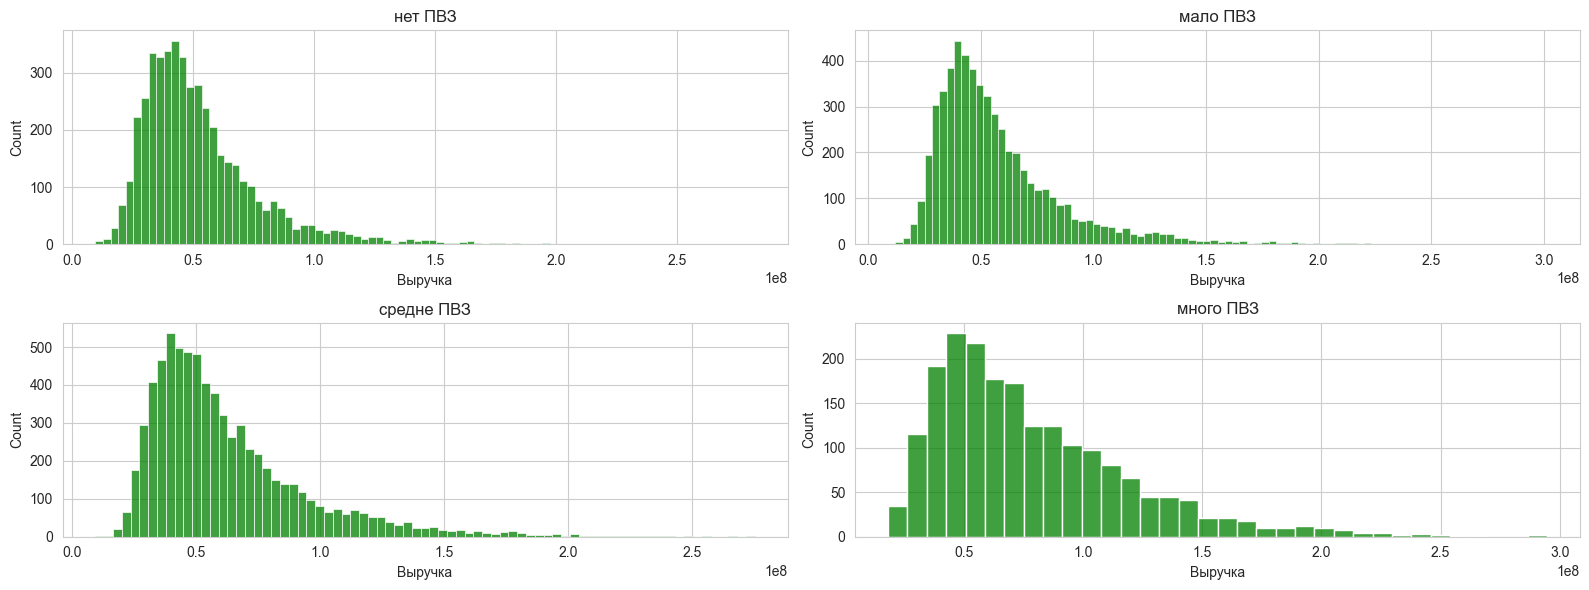

In [31]:
plt.figure(figsize=(16, 6))

plt.subplot(2,2,1)
sns.histplot(group1, color = 'green')
plt.title('нет ПВЗ')

plt.subplot(2,2,2)
sns.histplot(group2, color = 'green')
plt.title('мало ПВЗ')

plt.subplot(2,2,3)
sns.histplot(group3, color = 'green')
plt.title('средне ПВЗ')

plt.subplot(2,2,4)
sns.histplot(group4, color = 'green')
plt.title('много ПВЗ')
plt.tight_layout()
plt.show()

In [70]:
regions = data['Регион'].unique()
A = []
C = []
for reg in regions:
    s = data[data['Регион'] == reg].groupby('Населенный пункт', as_index = False).agg({'Численность населения':'mean'})['Численность населения'].sum()
    S = data[data['Регион'] == reg]['new_id'].nunique()
    A.append(s)
    C.append(S)
data_naselenie = pd.DataFrame({'Регион':regions, 'Население':A,'Количество магазинов':C})
data_naselenie['Население'].astype(float)
data_naselenie

,Регион,Население,Количество магазинов
0,Краснодарский край,4.529769e+06,1001
1,Свердловская обл,3.741786e+06,703
2,Московская обл,7.293756e+06,1709
3,Москва г,1.148485e+07,1373
4,Нижегородская обл,4.950548e+06,647
...,...,...,...
64,Красноярский край,1.899367e+06,168
65,Калининградская обл,7.263360e+05,54
66,Иркутская обл,1.427520e+06,83
67,Хабаровский край,1.011577e+06,66


In [72]:
regions = data['Регион'].unique()
k_znachim = 0
k_neznacnim = 0
reg = pd.DataFrame({
    'region': regions,
    'нет': [0]*len(regions),
    'мало': [0]*len(regions),
    'средне': [0]*len(regions),
    'много': [0]*len(regions)
})
k = -1
A = []
B = []
for region in regions:
    k += 1
    if len(region) > 3:
        ind = data[data['Регион'] == region]['new_id'].unique()
        df = df2[df2['new_id'].isin(ind)]
        df['pvz_groups'] = df['пвз'].apply(create_pvs_categories)
        groups = [df[df['pvz_groups'] == group]['Выручка'].dropna() for group in df['pvz_groups'].unique()]
        j = 0
        new = data_naselenie[data_naselenie['Регион'] == region]['Население'].sum()
        A.append(new)
        for gr in ['нет','мало','средне','много']:
            j += 1
            try:
                reg.iat[k, j] = len(df[df['pvz_groups'] == gr]['Выручка'])
            except:
                reg.iat[k, j] = 0
        if len(groups) > 2:
            h_stat, kruskal_p = kruskal(*groups)
            if kruskal_p < 0.05:
                B.append('значимо')
                print(f'{region}: p-value значим {kruskal_p} Население {new}')
                k_znachim += 1
            else:
                B.append('незначимо')
                print(f'{region}: p-value незначим {kruskal_p} Население {new}')
                k_neznacnim += 1
        else:
            B.append('Другой тест')
            print(f'{region}: другой тест нужен')
    else:
        print(f'{region}: кол-во наблюдений {len(region)}')

print(f'кол-во значимых отличий: {k_znachim}, кол-во незначимых {k_neznacnim}')
reg['Значимость'] = B

Краснодарский край: p-value значим 0.00012043463688744051 Население 4529768.740397285
Свердловская обл: p-value значим 1.0780599752823544e-05 Население 3741786.1737373737
Московская обл: p-value значим 8.093427434078555e-18 Население 7293755.696032762
Москва г: p-value значим 2.4417322105592888e-11 Население 11484846.043699928
Нижегородская обл: p-value значим 3.93651403937059e-08 Население 4950548.370678505
Марий Эл Респ: p-value незначим 0.8374213009464592 Население 450164.0
Псковская обл: p-value значим 0.018118155897660023 Население 633876.0
Владимирская обл: p-value значим 0.00010069905269062925 Население 1194687.1393939394
Самарская обл: p-value значим 0.002391151371139517 Население 2754182.958333333
Ростовская обл: p-value значим 0.0012409080876698547 Население 3337669.0
Ивановская обл: p-value незначим 0.42696939920755594 Население 777764.0
Пермский край: p-value значим 0.008883237096275719 Население 2014251.950099737
Костромская обл: p-value незначим 0.115303588794148 Населени

In [73]:
reg['Население'] = A
reg['Количество магазинов'] = C

In [74]:
reg

,region,нет,мало,средне,много,Значимость,Население,Количество магазинов
0,Краснодарский край,361,238,325,77,значимо,4.529769e+06,1001
1,Свердловская обл,169,239,251,44,значимо,3.741786e+06,703
2,Московская обл,328,440,644,297,значимо,7.293756e+06,1709
3,Москва г,188,310,492,383,значимо,1.148485e+07,1373
4,Нижегородская обл,143,210,234,60,значимо,4.950548e+06,647
...,...,...,...,...,...,...,...,...
64,Красноярский край,54,38,69,7,незначимо,1.899367e+06,168
65,Калининградская обл,20,15,18,1,значимо,7.263360e+05,54
66,Иркутская обл,38,19,23,3,незначимо,1.427520e+06,83
67,Хабаровский край,48,11,7,0,незначимо,1.011577e+06,66


In [66]:
df_y = reg.groupby('Значимость', as_index = False).agg({'Население':'sum'})
print(df_y.iloc[1,1]/df_y['Население'].sum())

0.313683947519325


In [75]:
df_y = reg.groupby('Значимость', as_index = False).agg({'Количество магазинов':'sum'})
df_y

,Значимость,Количество магазинов
0,значимо,14016
1,незначимо,5557


<Axes: xlabel='Население', ylabel='Значимость'>

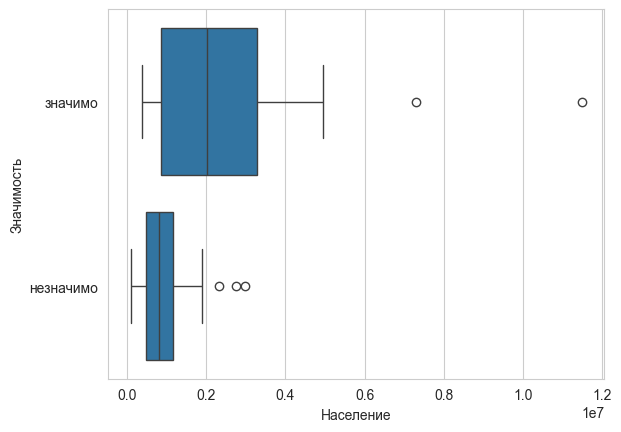

In [36]:
sns.boxplot(data = reg, x = 'Население', y = 'Значимость', orient = 'h')

In [37]:
data['Выручка'] = data['Трафик']*data['Средний чек']
mec = [1,2,3,4,5,6,7,8,9,10,11,12]
k_znachim = 0
k_neznacnim = 0
kvr = pd.DataFrame({
    'месяц': ['мес 1','мес 2','мес 3','мес 4','мес 5','мес 6','мес 7','мес 8','мес 9','мес 10','мес 11','мес 12'],
    'нет': [0]*12,
    'мало': [0]*12,
    'средне': [0]*12,
    'много': [0]*12
})

j = 0
k = -1
for i in mec:
    k += 1
    j += 1
    df = data[data['Месяц'] == i]
    df = df.groupby('new_id', as_index = False).agg({'Выручка':'mean', 'Трафик':'mean','Средний чек':'mean', 'пвз':'mean'}).copy()
    df['pvz_groups'] = df['пвз'].apply(create_pvs_categories)
    groups = [df[df['pvz_groups'] == group]['Выручка'].dropna() for group in df['pvz_groups'].unique()]
    if len(groups) > 2:
            h_stat, kruskal_p = kruskal(*groups)
            t = 0
            for gr in ['нет','мало','средне','много']:
                t += 1
                try:
                    kvr.iat[k, t] = len(df[df['pvz_groups'] == gr]['Выручка'])
                except:
                    kvr.iat[k, t] = 0
            if kruskal_p < 0.05:
                print(f'месяц {j}: p-value значим {kruskal_p}')
                k_znachim += 1
            else:
                print(f'{i}: p-value незначим {kruskal_p}')
                k_neznacnim += 1
    else:
            print(f'{i}: другой тест нужен')

print(f'кол-во значимых отличий: {k_znachim}, кол-во незначимых {k_neznacnim}')

месяц 1: p-value значим 2.571885191683561e-254
месяц 2: p-value значим 3.702151886206293e-257
месяц 3: p-value значим 3.9786374715806204e-241
месяц 4: p-value значим 1.9464992872046045e-205
месяц 5: p-value значим 2.0983248539802786e-169
месяц 6: p-value значим 4.887732163564678e-126
месяц 7: p-value значим 1.1539074035750683e-102
месяц 8: p-value значим 1.4381640048446468e-117
месяц 9: p-value значим 2.95956320564905e-165
месяц 10: p-value значим 6.661648736398206e-193
месяц 11: p-value значим 2.364373469896805e-219
месяц 12: p-value значим 2.7442156470666812e-216
кол-во значимых отличий: 12, кол-во незначимых 0


In [38]:
kvr

,месяц,нет,мало,средне,много
0,мес 1,4690,5634,7254,1995
1,мес 2,4690,5634,7254,1995
2,мес 3,4690,5634,7254,1995
3,мес 4,4690,5634,7254,1995
4,мес 5,4690,5634,7254,1995
5,мес 6,4690,5634,7254,1995
6,мес 7,4690,5634,7254,1995
7,мес 8,4690,5634,7254,1995
8,мес 9,4690,5634,7254,1995
9,мес 10,4690,5634,7254,1995


In [39]:
df2.to_csv('datacet_agr.csv')
data.to_csv('datacet_neagr.csv')

In [40]:
import pingouin as pg
result = pg.partial_corr(data=df2, x='пвз', y='Выручка', covar='Население')
print(result['r'].values[0])

0.1778162114832095


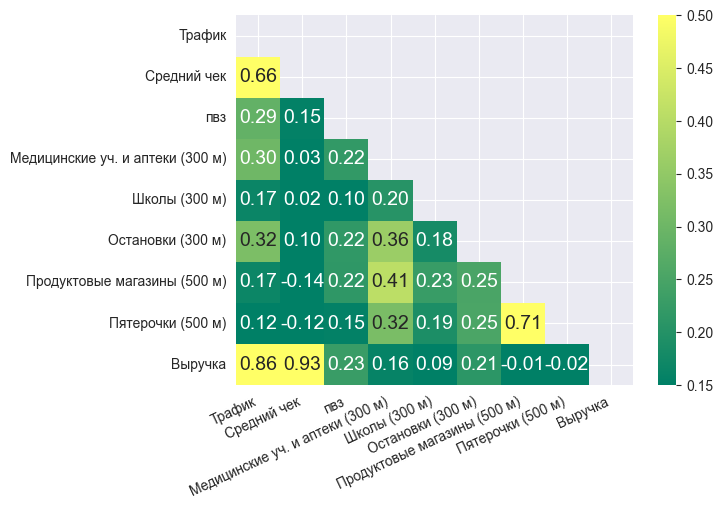

In [84]:
data['Выручка'] = data['Средний чек']*data['Трафик']
data.rename(columns={'Маркетплейсы, доставки, постаматы (100 м)' : 'пвз'}, inplace = True)
clear = data[['Трафик', 'Средний чек'\
              ,'пвз', 'Медицинские уч. и аптеки (300 м)', 'Школы (300 м)', 'Остановки (300 м)', 'Продуктовые магазины (500 м)', 'Пятерочки (500 м)', 'Выручка']]
correlation_matrix = clear.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, cmap='summer', vmin = 0.15, vmax = 0.5, annot=True, fmt='.2f',annot_kws={"size": 14})
plt.xticks(rotation=25, ha='right')
plt.show()

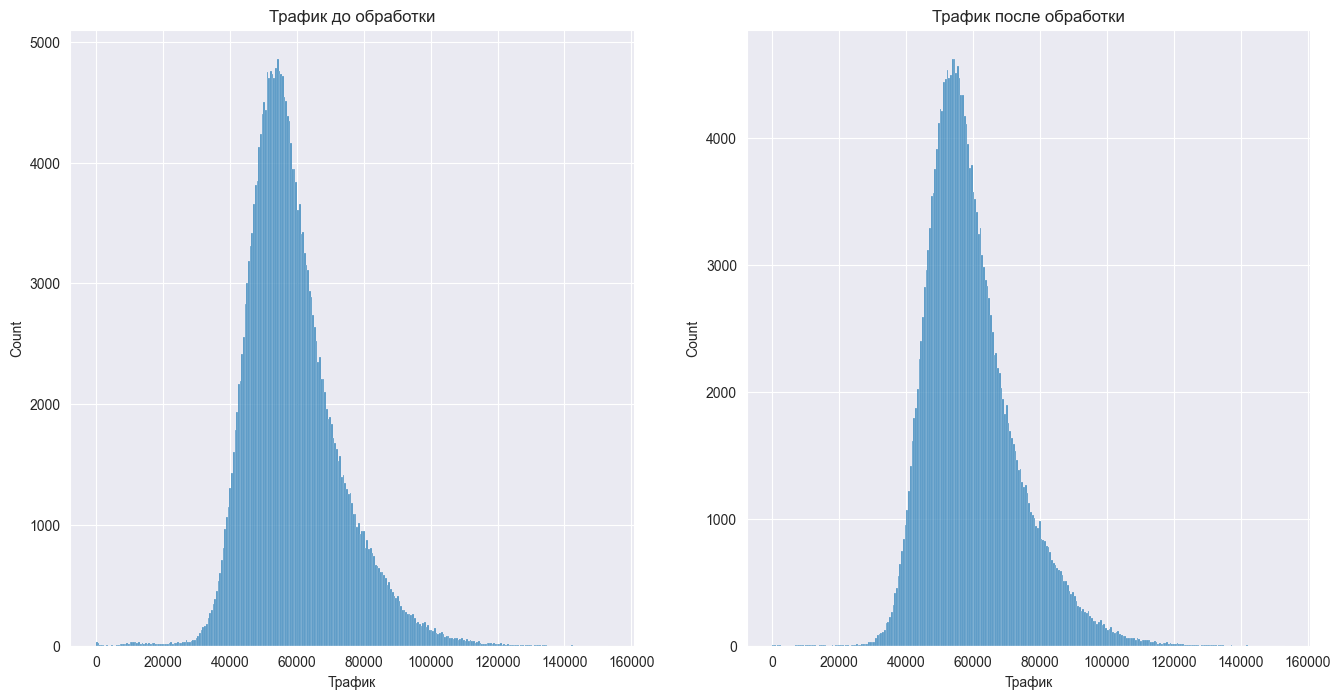

In [68]:
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
sns.histplot(data = data_basa, x='Трафик')
plt.title('Трафик до обработки')

plt.subplot(1,2,2)
sns.histplot(data = data, x='Трафик')
plt.title('Трафик после обработки')
plt.show()

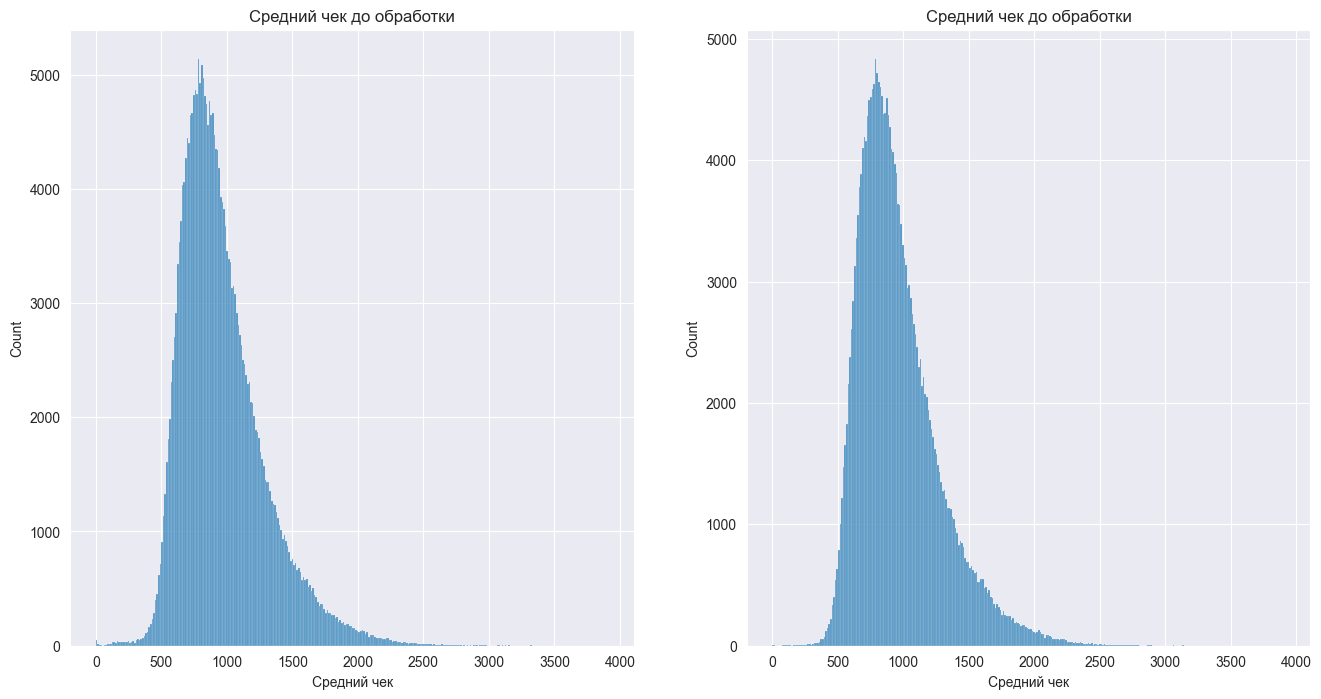

In [67]:
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
sns.histplot(data = data_basa, x='Средний чек')
plt.title('Средний чек до обработки')

plt.subplot(1,2,2)
sns.histplot(data = data, x='Средний чек')
plt.title('Средний чек до обработки')
plt.show()

In [76]:
data.columns

Index(['new_id', 'Месяц', 'Трафик', 'Средний чек',
       'Дата открытия, категориальный', 'Торговая площадь, категориальный',
       'Населенный пункт', 'Регион', 'Численность населения',
       'Количество домохозяйств', 'Трафик пеший, в час', 'Трафик авто, в час',
       'пвз', 'Медицинские уч. и аптеки (300 м)', 'Школы (300 м)',
       'Остановки (300 м)', 'Продуктовые магазины (500 м)',
       'Пятерочки (500 м)', 'Выручка'],
      dtype='object')

C:\Users\Michael\AppData\Local\Temp\ipykernel_13244\19632871.py:11: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



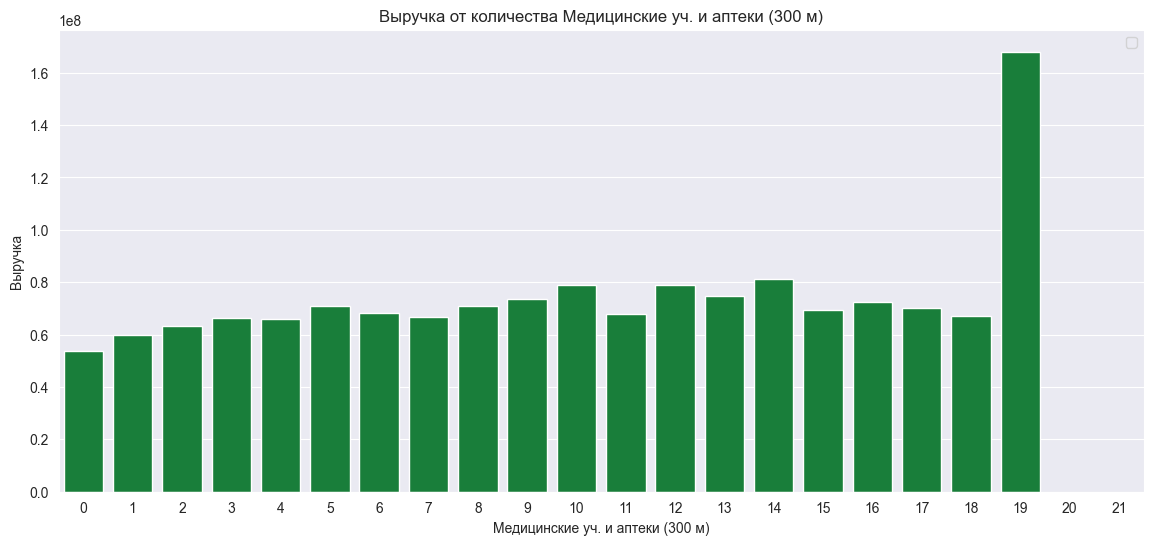

In [78]:
group_bar = data.groupby('Медицинские уч. и аптеки (300 м)', as_index = False).agg({'Выручка':'mean'})

plt.figure(figsize = (14,6))
x = group_bar['Медицинские уч. и аптеки (300 м)']
y = group_bar['Выручка']
x = x.astype(int)
ax = sns.barplot(x = x, y = y, color = dark_green, order=range(len(x)))

# Настройки
plt.title('Выручка от количества Медицинские уч. и аптеки (300 м)')
plt.legend()
plt.show()

C:\Users\Michael\AppData\Local\Temp\ipykernel_13244\1069095414.py:11: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



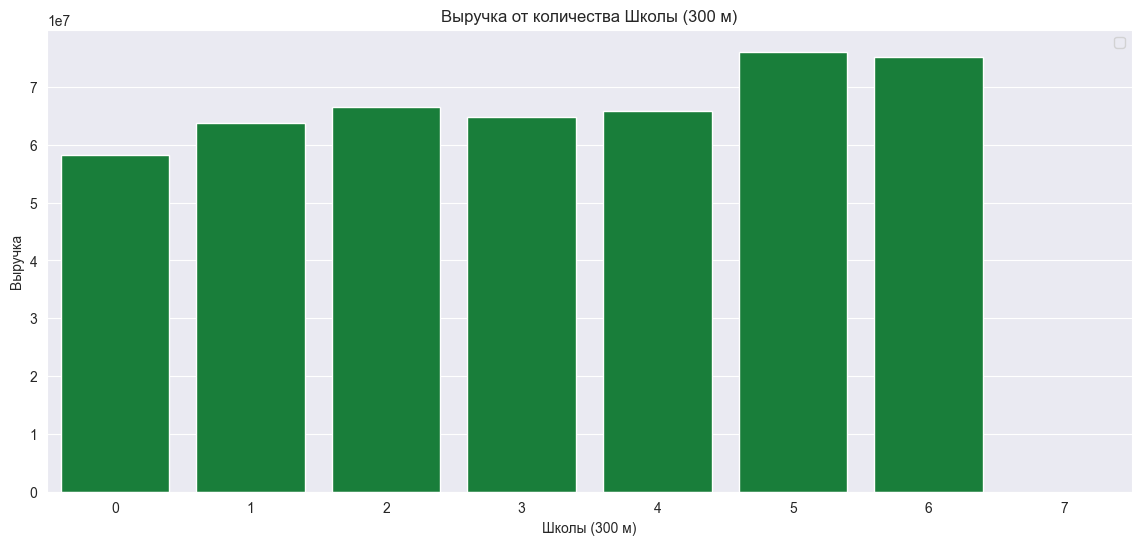

In [79]:
group_bar = data.groupby('Школы (300 м)', as_index = False).agg({'Выручка':'mean'})

plt.figure(figsize = (14,6))
x = group_bar['Школы (300 м)']
y = group_bar['Выручка']
x = x.astype(int)
ax = sns.barplot(x = x, y = y, color = dark_green, order=range(len(x)))

# Настройки
plt.title('Выручка от количества Школы (300 м)')
plt.legend()
plt.show()

C:\Users\Michael\AppData\Local\Temp\ipykernel_13244\2600816026.py:11: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



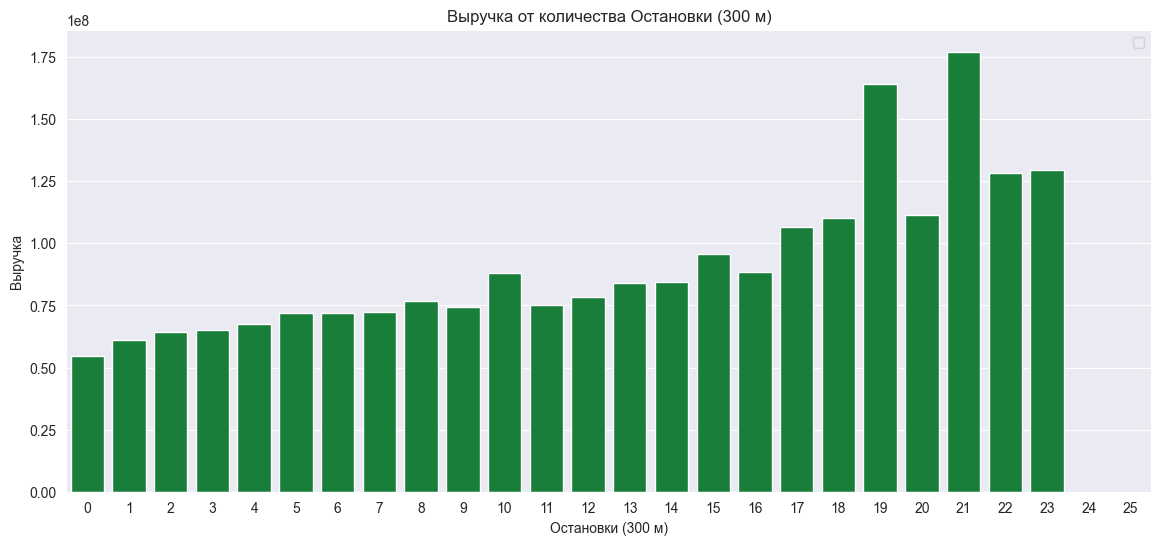

In [80]:
group_bar = data.groupby('Остановки (300 м)', as_index = False).agg({'Выручка':'mean'})

plt.figure(figsize = (14,6))
x = group_bar['Остановки (300 м)']
y = group_bar['Выручка']
x = x.astype(int)
ax = sns.barplot(x = x, y = y, color = dark_green, order=range(len(x)))

# Настройки
plt.title('Выручка от количества Остановки (300 м)')
plt.legend()
plt.show()

C:\Users\Michael\AppData\Local\Temp\ipykernel_13244\2998195076.py:11: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



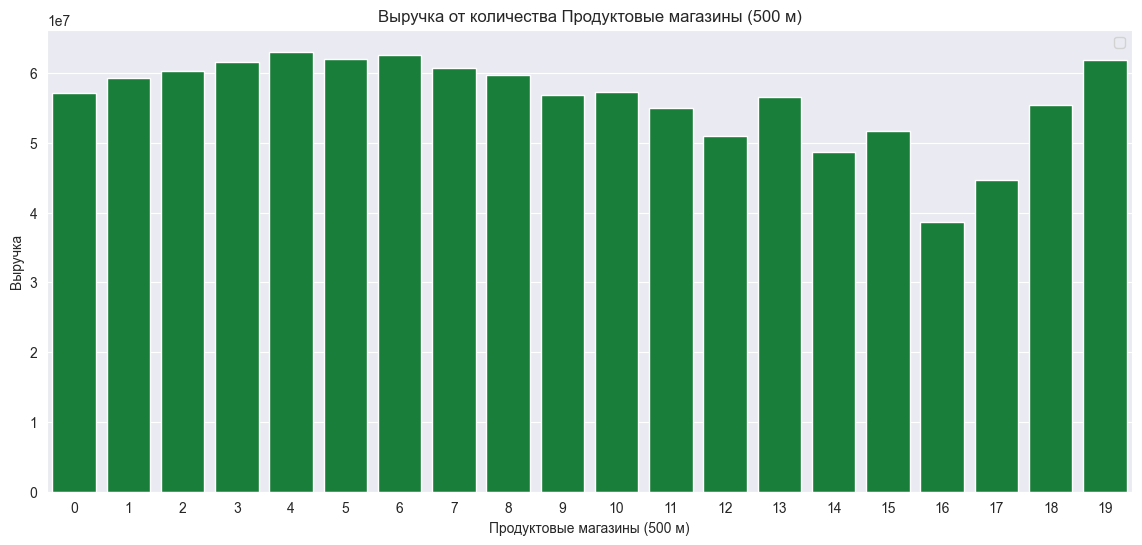

In [81]:
group_bar = data.groupby('Продуктовые магазины (500 м)', as_index = False).agg({'Выручка':'mean'})

plt.figure(figsize = (14,6))
x = group_bar['Продуктовые магазины (500 м)']
y = group_bar['Выручка']
x = x.astype(int)
ax = sns.barplot(x = x, y = y, color = dark_green, order=range(len(x)))

# Настройки
plt.title('Выручка от количества Продуктовые магазины (500 м)')
plt.legend()
plt.show()